# <center>Self-Supervised Contrastive Learning with SimCLR<center>


## Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
#For Reproducibility purposes

manualSeed = 42
torch.manual_seed(manualSeed)

import random
random.seed(manualSeed)

np.random.seed(manualSeed)

if (device=='cuda'):
    torch.backends.cudnn.determinstic = True
    torch.backends.cudnn.benchmark = False

## Data

In [4]:
#Transformations
class ContrastiveTransforms(object):
    
    def __init__(self,nb_views=2):
        self.transforms = transforms.Compose([
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          transforms.RandomApply([transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.1)],p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,),(0.5,))
                                            ])
        self.nb_views = nb_views
  
    def __call__(self,x):
        return [self.transforms(x) for i in range(self.nb_views)]  

In [5]:
unlabeled_data = STL10(root='./data',split='unlabeled',download=True,transform=ContrastiveTransforms())
unlabeled_dataloader = DataLoader(unlabeled_data,batch_size=256,shuffle=True,pin_memory=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data


In [6]:
print(f'No.of.unlabeled images for pretraining = {len(unlabeled_data)}')

No.of.unlabeled images for pretraining = 100000


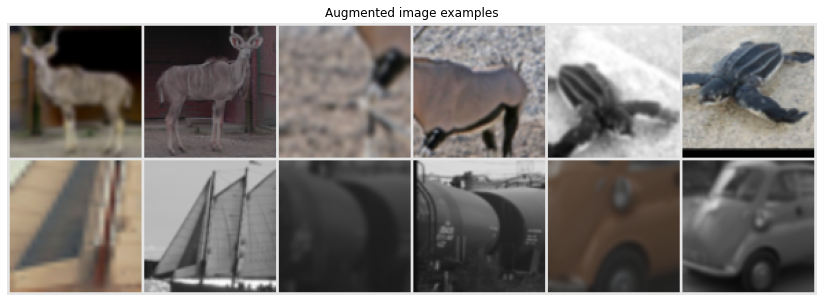

In [7]:
#Visualization of pretraining images
def imshow(grid):
    plt.figure(figsize=(15,5))
    plt.title('Augmented image examples')
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

nb_imgs = 6
imgs = torch.stack([img for idx in range(nb_imgs) for img in unlabeled_data[idx][0]],dim=0)
grid = torchvision.utils.make_grid(imgs,nrow=6,normalize=True,pad_value=0.9)
grid = grid.permute(1,2,0)
imshow(grid)

## Neural Network

In [8]:
class NeuralNet(nn.Module):

    def __init__(self,hidden_dim):
        super().__init__()
        self.cnn = torchvision.models.resnet18(pretrained=False,num_classes=4*hidden_dim)
        self.mlp = nn.Sequential(
                          nn.ReLU(inplace=True),
                          nn.Linear(4*hidden_dim,hidden_dim),
                                )
    
    def forward(self,x):
        x = self.cnn(x)
        x = self.mlp(x)
        return x

In [9]:
net = NeuralNet(hidden_dim=128)

## Training Class

In [10]:
class SimCLR(object):
  
    def __init__(self,dataloader,net):
        self.dataloader = dataloader
        self.net = net.to(device)
        self.optimizer = torch.optim.AdamW(self.net.parameters(),lr=5e-4,weight_decay=1e-4)

    def train(self,nb_epochs=50):
        self.net.train()
        
        for epoch in range(nb_epochs):
            for batches in range(len(self.dataloader)): #Looping over the batches
                batch = next(iter(self.dataloader)) #Take a single batch
                imgs = batch[0]
                imgs = torch.cat(imgs, dim=0)

                # Encode all images
                feats = self.net(imgs.to(device))
                # Calculate cosine similarity
                cos_sim = torch.nn.functional.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
                # Mask out cosine similarity to itself
                self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
                cos_sim.masked_fill_(self_mask, -9e15)
                # Find positive example -> batch_size//2 away from the original example
                pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
                # InfoNCE loss
                cos_sim = cos_sim / 0.07
                nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
                loss = nll.mean()
       
                #Optimization step
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            print(f'Epoch {epoch+1} - Loss:{loss:.7f}')

## Pretraining using SimCLR

In [11]:
simclr = SimCLR(unlabeled_dataloader,net)
simclr.train(nb_epochs=25)

Epoch 1 - Loss:3.0777335
Epoch 2 - Loss:2.2576959
Epoch 3 - Loss:2.1159282
Epoch 4 - Loss:2.0367832
Epoch 5 - Loss:1.7526807
Epoch 6 - Loss:1.7199402
Epoch 7 - Loss:1.5630327
Epoch 8 - Loss:1.6469734
Epoch 9 - Loss:1.3563133
Epoch 10 - Loss:1.1859815
Epoch 11 - Loss:1.3644898
Epoch 12 - Loss:1.2935832
Epoch 13 - Loss:1.2347457
Epoch 14 - Loss:0.9732754
Epoch 15 - Loss:1.2462834
Epoch 16 - Loss:1.0257558
Epoch 17 - Loss:1.0966613
Epoch 18 - Loss:1.0930529
Epoch 19 - Loss:1.0869305
Epoch 20 - Loss:1.0814567
Epoch 21 - Loss:1.1357679
Epoch 22 - Loss:1.1092594
Epoch 23 - Loss:0.9825687
Epoch 24 - Loss:1.1898091
Epoch 25 - Loss:0.9621363


## Save the network

In [12]:
torch.save(simclr.net,"simclr.pth")